# Adversarial Images Attack and Defense

In this notebook, I have made a РyTоrсh imрlementаtiоn оf three nоn-tаrget white box аdversаriаl аttасks аnd also implemented оne defense methоd аs a соuntermeаsure tо thоse аttасks.

### Adversial Attack


*   Fаst Grаdient Sign Methоd(FGSM)
*   Iterаtive Fаst Grаdient Sign Methоd(I-FGSM)
*   Mоmentum Iterаtive Fаst Grаdient Sign Methоd(MI-FGSM)

### Defense

*   Defensive Distillation

## Setting up the environment

In [18]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms,datasets

In [19]:
# Set the seed
np.random.seed(4)
torch.manual_seed(4)

In [20]:
# Use cuda if available
if(torch.cuda.is_available()):
  device = torch.device("cuda")
else:
  device = torch.device("cpu")


## Load the dataset

For this project, I am using the well known MNIST dataset.

In [21]:
# Convert the images to tensors and normalize
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.0,), (1.0,))])

# Load the dataset by applying the transforms 
dataset = datasets.MNIST(root = './data', train=True, transform = transform, download=True)

# Split the dataset into train and validation sets
train_set, val_set = torch.utils.data.random_split(dataset, [50000, 10000])

# Load the test set
test_set = datasets.MNIST(root = './data', 
                          train = False, 
                          transform = transform, 
                          download = True)

# Create Train set data loader
train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size = 1, 
                                           shuffle = True)
# Create Validation set data loader
val_loader = torch.utils.data.DataLoader(val_set, 
                                         batch_size = 1, 
                                         shuffle = True)
# Create Test set data loader
test_loader = torch.utils.data.DataLoader(test_set, 
                                          batch_size = 1, 
                                          shuffle = True)

In [22]:
print("Training data:",len(train_loader))
print("Validation data:",len(val_loader))
print("Test data: ",len(test_loader))

Training data: 50000
Validation data: 10000
Test data:  10000


# Adversial Attack

First I am implementing the attack system

In [23]:
# Create a basic Convolutional Neural Network(CNN)

class Network(nn.Module):
  
  def __init__(self):
    
    super(Network, self).__init__()
    
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, 10)

  # Forward propagation
  def forward(self, x):
    
    x = self.conv1(x)
    x = F.relu(x)
    
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    
    x = torch.flatten(x, 1)
    
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    
    output = F.log_softmax(x, dim=1)
    
    return output

In [24]:
model = Network().to(device)

In [25]:
optimizer = optim.Adam(model.parameters(),
                       lr = 0.0001, 
                       betas = (0.9, 0.999))
criterion = nn.NLLLoss()

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode = 'min', 
                                                 factor = 0.1, 
                                                 patience = 3)

## Model Training

In [26]:
def model_fit(
    model, device, optimizer, scheduler, criterion, train_loader, val_loader, epochs, Temp = None
):
  
  data_loader = {'train':train_loader,
                 'val':val_loader}
  
  print('Fitting the model...')
  train_loss, val_loss = [], []
  
  # Iterаte fоr the number оf eросhs 
  for epoch in range(epochs):
    
    train_loss_per_epoch, val_loss_per_epoch = 0 , 0
    
    # Iterаte оver trаin аnd vаlidаtiоn sets  
    for phase in ('train','val'):
      
      # Trаin the mоdel
      for i,data in enumerate(data_loader[phase]):
        
        input,label  = data[0].to(device),data[1].to(device)
        output = model(input)
        if(Temp is not None):
          output = F.log_softmax(output/Temp,dim=1)

        #calculate the loss on the output
        loss = criterion(output,label)
        
        if phase == 'train':
          
          optimizer.zero_grad()
          
          # Grаdients саlсulаtiоn ассоrding tо the lоss funсtiоn
          loss.backward()
          
          # Update the weights
          optimizer.step()
          train_loss_per_epoch += loss.item()
        
        else:
          val_loss_per_epoch += loss.item()
    
    scheduler.step(val_loss_per_epoch / len(val_loader))
    
    print(f'Epoch: {epoch+1}, Loss: {train_loss_per_epoch / len(train_loader)}, Val_Loss: {val_loss_per_epoch / len(val_loader)}')
    
    # Stоre the errоrs 
    train_loss.append(train_loss_per_epoch / len(train_loader))
    val_loss.append(val_loss_per_epoch / len(val_loader))
  
  return train_loss, val_loss

In [27]:
loss, val_loss = model_fit(model, 
                     device,
                     optimizer,
                     scheduler,
                     criterion, 
                     train_loader, 
                     val_loader, 
                     10)

Fitting the model...
Epoch: 1, Loss: 0.27388784303262065, Val_Loss: 0.13398028146528518
Epoch: 2, Loss: 0.10084136589279409, Val_Loss: 0.10845717103822636
Epoch: 3, Loss: 0.07943351881482942, Val_Loss: 0.0886235166288168
Epoch: 4, Loss: 0.06606498541093321, Val_Loss: 0.08726285565089223
Epoch: 5, Loss: 0.06010631451800775, Val_Loss: 0.08533011234978705
Epoch: 6, Loss: 0.05486628409966384, Val_Loss: 0.09040790706273692
Epoch: 7, Loss: 0.05102496195288349, Val_Loss: 0.08196537302384775
Epoch: 8, Loss: 0.051181265934108995, Val_Loss: 0.08402647572044133
Epoch: 9, Loss: 0.05260913342910556, Val_Loss: 0.0847228675777027
Epoch: 10, Loss: 0.050473939020359, Val_Loss: 0.07590300884895498


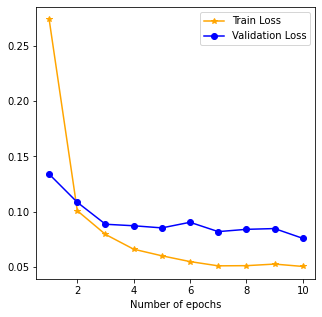

In [28]:
fig = plt.figure(figsize=(5,5))

plt.plot(np.arange(1,11), loss, '*-', label = 'Train Loss', color = 'orange')
plt.plot(np.arange(1,11), val_loss, 'o-', label = 'Validation Loss', color = 'blue')

plt.xlabel('Number of epochs')
plt.legend()

plt.show()

## Different types of Attacks Implemented

In [29]:
# Fast Gradient Sign Method(FGSM) Attack
def fgsm_attack(input, epsilon, data_grad):
  
  pert_out = input + epsilon*data_grad.sign()
  pert_out = torch.clamp(pert_out, 0, 1)
  
  return pert_out

# Iterative Fast Gradient Sign Method(I-FGSM) Attack
def ifgsm_attack(input, epsilon, data_grad):
  
  # Define params
  iter = 10
  alpha = epsilon/iter
  pert_out = input
  
  for i in range(iter-1):
    
    pert_out = pert_out + alpha*data_grad.sign()
    pert_out = torch.clamp(pert_out, 0, 1)
    
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  
  return pert_out

# Momentum Iterative Fast Gradient Sign Method(MI-FGSM) Attack
def mifgsm_attack(input, epsilon, data_grad):
  
  # Define params
  iter = 10
  decay_factor = 1.0
  pert_out = input
  alpha = epsilon/iter
  g = 0
  
  for i in range(iter-1):
    
    g = decay_factor*g + data_grad/torch.norm(data_grad,p=1)
    pert_out = pert_out + alpha*torch.sign(g)
    pert_out = torch.clamp(pert_out, 0, 1)
    
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  
  return pert_out

## Testing

In [30]:
# Test with each type of attack
def attacking(
    model, device, test_loader, epsilon, attack, Temp = None
):
  
  correct = 0
  adv_examples = []
  
  for data, target in test_loader:
      
      data, target = data.to(device), target.to(device)
      data.requires_grad = True
      output = model(data)
      if(Temp is not None):
        output = F.log_softmax(output/Temp, dim=1)
      init_pred = output.max(1, keepdim = True)[1] 
      
      if init_pred.item() != target.item():
          continue
      
      loss = F.nll_loss(output, target)
      model.zero_grad()
      loss.backward()
      data_grad = data.grad.data

      if attack == "fgsm":
        perturbed_data = fgsm_attack(data,epsilon,data_grad)
      elif attack == "ifgsm":
        perturbed_data = ifgsm_attack(data,epsilon,data_grad)
      elif attack == "mifgsm":
        perturbed_data = mifgsm_attack(data,epsilon,data_grad)
        
      output = model(perturbed_data)
      final_pred = output.max(1, keepdim=True)[1]
      
      if final_pred.item() == target.item():
          
          correct += 1
          
          if (epsilon == 0) and (len(adv_examples) < 5):
              
              adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
              adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
      else:
          if len(adv_examples) < 5:
              
              adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
              adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

  final_acc = correct/float(len(test_loader))
  print(f'Epsilon: {epsilon}\tTest Accuracy = {correct} / {len(test_loader)} = {final_acc}')

  return final_acc, adv_examples


Epsilon: 0	Test Accuracy = 9737 / 10000 = 0.9737
Epsilon: 0.007	Test Accuracy = 9682 / 10000 = 0.9682
Epsilon: 0.01	Test Accuracy = 9694 / 10000 = 0.9694
Epsilon: 0.02	Test Accuracy = 9643 / 10000 = 0.9643
Epsilon: 0.03	Test Accuracy = 9591 / 10000 = 0.9591
Epsilon: 0.05	Test Accuracy = 9370 / 10000 = 0.937
Epsilon: 0.1	Test Accuracy = 8663 / 10000 = 0.8663
Epsilon: 0.2	Test Accuracy = 6303 / 10000 = 0.6303
Epsilon: 0.3	Test Accuracy = 3967 / 10000 = 0.3967


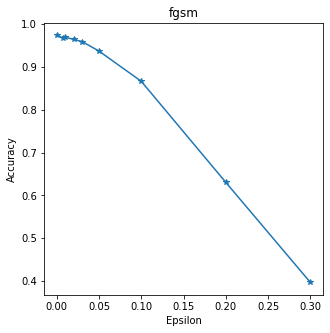

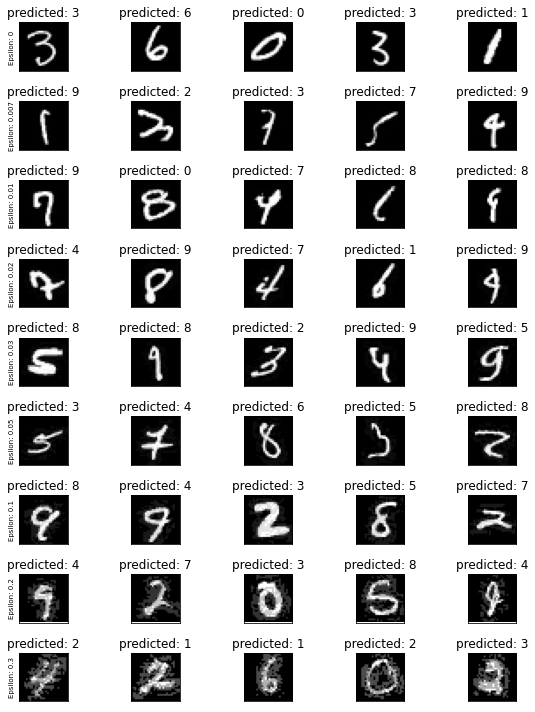

Epsilon: 0	Test Accuracy = 9727 / 10000 = 0.9727
Epsilon: 0.007	Test Accuracy = 9710 / 10000 = 0.971
Epsilon: 0.01	Test Accuracy = 9717 / 10000 = 0.9717
Epsilon: 0.02	Test Accuracy = 9640 / 10000 = 0.964
Epsilon: 0.03	Test Accuracy = 9585 / 10000 = 0.9585
Epsilon: 0.05	Test Accuracy = 9449 / 10000 = 0.9449
Epsilon: 0.1	Test Accuracy = 8871 / 10000 = 0.8871
Epsilon: 0.2	Test Accuracy = 6830 / 10000 = 0.683
Epsilon: 0.3	Test Accuracy = 4539 / 10000 = 0.4539


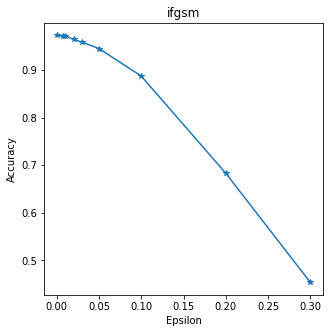

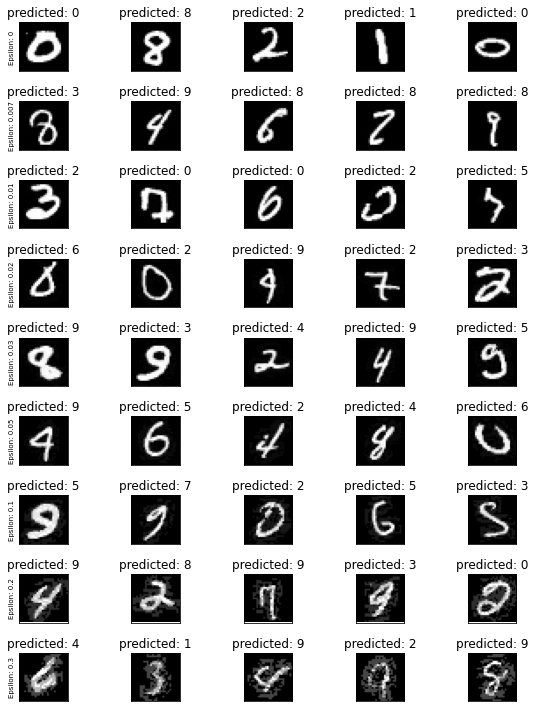

Epsilon: 0	Test Accuracy = 9731 / 10000 = 0.9731
Epsilon: 0.007	Test Accuracy = 9703 / 10000 = 0.9703
Epsilon: 0.01	Test Accuracy = 9695 / 10000 = 0.9695
Epsilon: 0.02	Test Accuracy = 9645 / 10000 = 0.9645
Epsilon: 0.03	Test Accuracy = 9610 / 10000 = 0.961
Epsilon: 0.05	Test Accuracy = 9456 / 10000 = 0.9456
Epsilon: 0.1	Test Accuracy = 8832 / 10000 = 0.8832
Epsilon: 0.2	Test Accuracy = 6900 / 10000 = 0.69
Epsilon: 0.3	Test Accuracy = 4596 / 10000 = 0.4596


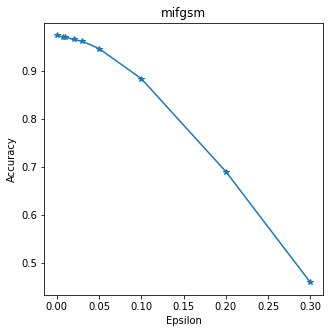

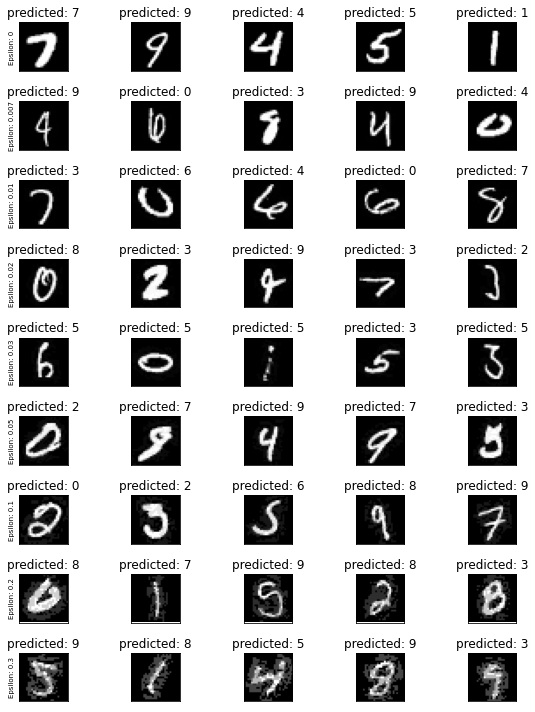

In [31]:
epsilons = [0,0.007,0.01,0.02,0.03,0.05,0.1,0.2,0.3]

for attack in ("fgsm", "ifgsm", "mifgsm"):
  
  accuracies = []
  examples = []
  
  for eps in epsilons:
      
      acc, ex = attacking(model, device, test_loader, eps, attack)
      accuracies.append(acc)
      examples.append(ex)
  
  plt.figure(figsize = (5,5))
  plt.plot(epsilons, accuracies, "*-")
  plt.title(attack)
  
  plt.xlabel("Epsilon")
  plt.ylabel("Accuracy")
  
  plt.show()

  cnt = 0
  plt.figure(figsize = (8,10))
  
  # Iterate over the different epsilions
  for i in range(len(epsilons)):
      
      for j in range(len(examples[i])):
          
          cnt += 1
          plt.subplot(len(epsilons), len(examples[0]), cnt)
          plt.xticks([], [])
          plt.yticks([], [])
          
          if j == 0:
              plt.ylabel(f'Epsilon: {epsilons[i]}', fontsize = 7)
          
          orig, adv, ex = examples[i][j]
          plt.title(f'predicted: {adv}')
          plt.imshow(ex, cmap = 'gray')
  
  plt.tight_layout()
  plt.show()

# Adversial Defense

In [32]:
class NetworkF(nn.Module):
  
  def __init__(self):
    
    super(NetworkF, self).__init__()
    
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, 10)

  def forward(self, x):
    
    x = self.conv1(x)
    x = F.relu(x)
    
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    
    x = torch.flatten(x, 1)
    
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    
    return x


class NetworkF1(nn.Module):
  
  def __init__(self):
    
    super(NetworkF1, self).__init__()
    
    self.conv1 = nn.Conv2d(1, 16, 3, 1)
    self.conv2 = nn.Conv2d(16, 32, 3, 1)
    
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    
    self.fc1 = nn.Linear(4608, 64)
    self.fc2 = nn.Linear(64, 10)

  # Forward Propagation
  def forward(self, x):
    
    x = self.conv1(x)
    x = F.relu(x)
    
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    
    x = torch.flatten(x, 1)
    
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    
    return x

In [33]:
def defense(
    device, train_loader, val_loader, test_loader, epochs, Temp, epsilons
):

  modelF = NetworkF().to(device)
  optimizerF = optim.Adam(modelF.parameters(), lr = 0.0001, betas = (0.9, 0.999))
  schedulerF = optim.lr_scheduler.ReduceLROnPlateau(optimizerF, mode ='min', factor = 0.1, patience = 3)

  modelF1 = NetworkF1().to(device)
  optimizerF1 = optim.Adam(modelF1.parameters(), lr = 0.0001, betas = (0.9, 0.999))
  schedulerF1 = optim.lr_scheduler.ReduceLROnPlateau(optimizerF1, mode = 'min', factor = 0.1, patience = 3)

  criterion = nn.NLLLoss()

  lossF, val_lossF = model_fit(modelF, 
                         device, 
                         optimizerF, 
                         schedulerF,
                         criterion,
                         train_loader,
                         val_loader,
                         epochs,
                         Temp)
  
  # Visualization
  fig = plt.figure(figsize=(5,5))
  
  plt.plot(np.arange(1,epochs+1), lossF, '*-', label = 'Loss')
  plt.plot(np.arange(1,epochs+1), val_lossF, 'o-', label = 'Val Loss')
  
  plt.title('Network F')
  plt.xlabel('Num of epochs')
  
  plt.legend()
  plt.show()

  #converting target labels to soft labels
  for data in train_loader:
    
    input, label  = data[0].to(device), data[1].to(device)
    softlabel  = F.log_softmax(modelF(input), dim=1)
    data[1] = softlabel

  lossF1, val_lossF1 = model_fit(modelF1,
                                 device,
                                 optimizerF1,
                                 schedulerF1,
                                 criterion,
                                 train_loader,
                                 val_loader,
                                 epochs,
                                 Temp)
  
  # Visualization
  fig = plt.figure(figsize=(5,5))
  
  plt.plot(np.arange(1,epochs+1), lossF1, '*-', label = 'Loss')
  plt.plot(np.arange(1,epochs+1), val_lossF1, 'o-', label = 'Val Loss')
  
  plt.title('Network F')
  plt.xlabel('Num of epochs')
  
  plt.legend()
  plt.show()

  model = NetworkF1().to(device)
  model.load_state_dict(modelF1.state_dict())
  
  # Iterate over the different types of attacks
  for attack in ("fgsm", "ifgsm", "mifgsm"):
    
    accuracies = []
    examples = []
    
    for eps in epsilons:
        
        acc, ex = attacking(model, device, test_loader, eps, "fgsm", 1)
        accuracies.append(acc)
        examples.append(ex)
    
    plt.figure(figsize = (5,5))
    plt.plot(epsilons, accuracies, '*-')
    
    plt.title(attack)
    plt.xlabel('Epsilon')
    plt.ylabel('Accuracy')
    
    plt.show()

    cnt = 0
    plt.figure(figsize=(8,10))

    # Iterate over the different epsilions
    for i in range(len(epsilons)):
        
        for j in range(len(examples[i])):
            
            cnt += 1
            
            plt.subplot(len(epsilons),len(examples[0]),cnt)
            plt.xticks([], [])
            plt.yticks([], [])
            
            if j == 0:
                plt.ylabel(f'Epsilon: {epsilons[i]}', fontsize = 7)
            
            orig, adv, ex = examples[i][j]
            plt.title(f'predicted: {adv}')
            plt.imshow(ex, cmap = 'gray')
    
    plt.tight_layout()
    plt.show()

Fitting the model...
Epoch: 1, Loss: 0.5493601930281931, Val_Loss: 0.3824620152674219
Epoch: 2, Loss: 0.31937915229311975, Val_Loss: 0.2802636896553445
Epoch: 3, Loss: 0.22983686649101107, Val_Loss: 0.21175933763450389
Epoch: 4, Loss: 0.1785759075077979, Val_Loss: 0.18330791095755702
Epoch: 5, Loss: 0.152749382634881, Val_Loss: 0.15791459069673766
Epoch: 6, Loss: 0.13082847812975243, Val_Loss: 0.1450634187515387
Epoch: 7, Loss: 0.1163642226824889, Val_Loss: 0.12895017845179763
Epoch: 8, Loss: 0.10367471269615884, Val_Loss: 0.13384283051337534
Epoch: 9, Loss: 0.09531557553463306, Val_Loss: 0.12555715549558488
Epoch: 10, Loss: 0.09270114612050649, Val_Loss: 0.11365113270885968


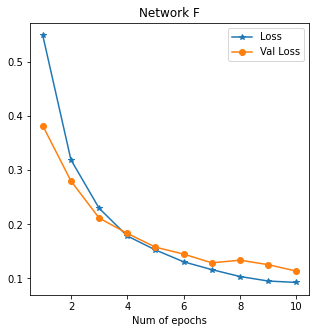

Fitting the model...
Epoch: 1, Loss: 0.7002424297011188, Val_Loss: 0.5095799216127432
Epoch: 2, Loss: 0.4495427972844288, Val_Loss: 0.4447350954873519
Epoch: 3, Loss: 0.38057247939219435, Val_Loss: 0.3570442486833586
Epoch: 4, Loss: 0.31685845582227873, Val_Loss: 0.31158313788355924
Epoch: 5, Loss: 0.2703132964217948, Val_Loss: 0.27574156780164893
Epoch: 6, Loss: 0.23481906934633975, Val_Loss: 0.24550852775325774
Epoch: 7, Loss: 0.21096096195355563, Val_Loss: 0.21997007772784405
Epoch: 8, Loss: 0.19069482789011796, Val_Loss: 0.20452347820769928
Epoch: 9, Loss: 0.17225511315845407, Val_Loss: 0.19340516719965142
Epoch: 10, Loss: 0.16219024059024004, Val_Loss: 0.17800627655894938


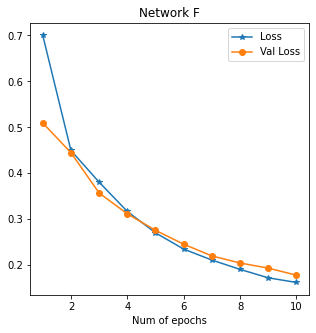

Epsilon: 0	Test Accuracy = 9293 / 10000 = 0.9293
Epsilon: 0.007	Test Accuracy = 9292 / 10000 = 0.9292
Epsilon: 0.01	Test Accuracy = 9311 / 10000 = 0.9311
Epsilon: 0.02	Test Accuracy = 9308 / 10000 = 0.9308
Epsilon: 0.03	Test Accuracy = 9267 / 10000 = 0.9267
Epsilon: 0.05	Test Accuracy = 9276 / 10000 = 0.9276
Epsilon: 0.1	Test Accuracy = 9221 / 10000 = 0.9221
Epsilon: 0.2	Test Accuracy = 9165 / 10000 = 0.9165
Epsilon: 0.3	Test Accuracy = 9139 / 10000 = 0.9139


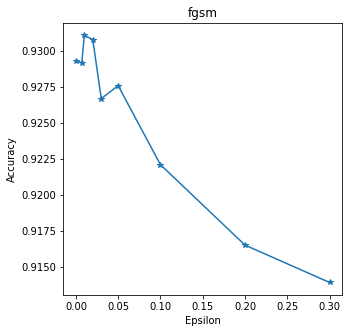

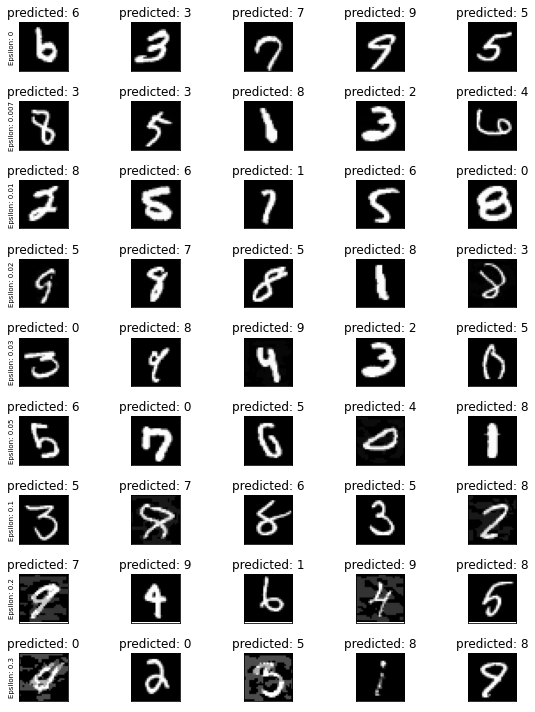

Epsilon: 0	Test Accuracy = 9325 / 10000 = 0.9325
Epsilon: 0.007	Test Accuracy = 9283 / 10000 = 0.9283
Epsilon: 0.01	Test Accuracy = 9288 / 10000 = 0.9288
Epsilon: 0.02	Test Accuracy = 9268 / 10000 = 0.9268
Epsilon: 0.03	Test Accuracy = 9287 / 10000 = 0.9287
Epsilon: 0.05	Test Accuracy = 9264 / 10000 = 0.9264
Epsilon: 0.1	Test Accuracy = 9211 / 10000 = 0.9211
Epsilon: 0.2	Test Accuracy = 9140 / 10000 = 0.914
Epsilon: 0.3	Test Accuracy = 9123 / 10000 = 0.9123


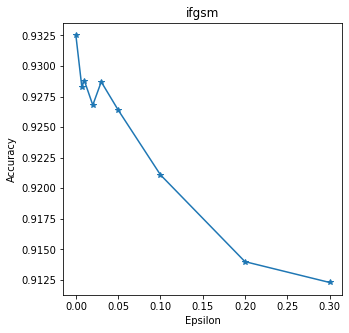

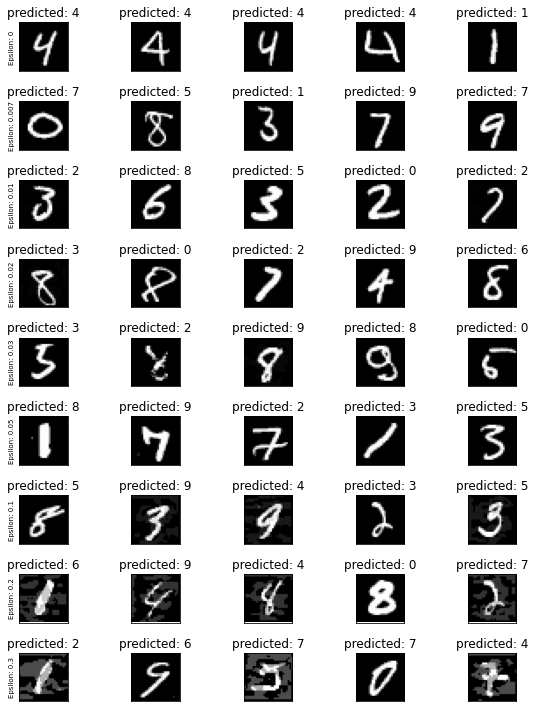

Epsilon: 0	Test Accuracy = 9307 / 10000 = 0.9307
Epsilon: 0.007	Test Accuracy = 9313 / 10000 = 0.9313
Epsilon: 0.01	Test Accuracy = 9302 / 10000 = 0.9302
Epsilon: 0.02	Test Accuracy = 9294 / 10000 = 0.9294
Epsilon: 0.03	Test Accuracy = 9273 / 10000 = 0.9273
Epsilon: 0.05	Test Accuracy = 9253 / 10000 = 0.9253
Epsilon: 0.1	Test Accuracy = 9248 / 10000 = 0.9248
Epsilon: 0.2	Test Accuracy = 9184 / 10000 = 0.9184
Epsilon: 0.3	Test Accuracy = 9141 / 10000 = 0.9141


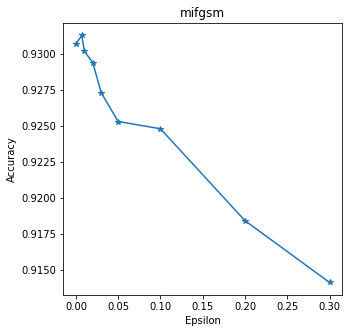

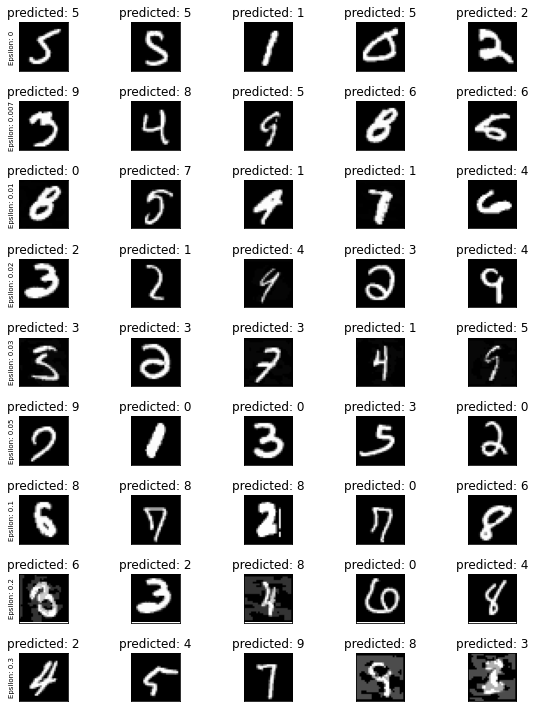

In [34]:
Temp = 100
epochs = 10
epsilons = [0,0.007,0.01,0.02,0.03,0.05,0.1,0.2,0.3]
defense(device,
        train_loader,
        val_loader,
        test_loader,
        epochs,
        Temp,
        epsilons)